In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches

In [2]:
# Open dataset 
dir = '/home/jovyan/SOARS_2021/Data/CESM2/'
fn = 'tos_Omon_CESM2_omip2_r1i1p1f1_gr_030601-036612.nc'

data_tos = xr.open_dataset(dir+fn)
data_tos

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (d2: 2, lat: 180, lon: 360, time: 732)
Coordinates:
  * time       (time) object 0306-01-15 12:00:00 ... 0366-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    tos        (time, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            OMIP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    case_id:                1540
    ...                     ...
    tracking_id:            hdl:21.14100/035f5fb2-1e7b-46a3-a72f-268f1f6ea194
    variable_id:            tos
    variant_info:           CMIP6 omip2 experiment (JRA forcing) with interac...
    variant_label:          r1i1p1f1
    source_type:            OGCM BGC
    comment:                Experiment run for 6 cycles of 1958-2018 JRA55 fo...

In [3]:
# Change the time to be from DatetimeNoLeap to a Datetime64
data_tos['time'] = np.arange('1958-01-01','2019-01-01',dtype = 'datetime64[M]')
data_tos

<xarray.Dataset>
Dimensions:    (d2: 2, lat: 180, lon: 360, time: 732)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2018-12-01
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object 0306-01-01 00:00:00 ... 0367-01-01 00:00:00
    lat_bnds   (lat, d2) float64 -90.0 -89.0 -89.0 -88.0 ... 88.0 89.0 89.0 90.0
    lon_bnds   (lon, d2) float64 0.0 1.0 1.0 2.0 2.0 ... 358.0 359.0 359.0 360.0
    tos        (time, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            OMIP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    case_id:                1540
    ...                     ...
    tracking_id:            hdl:21.14100/035f5fb2-1e7b-46a3-a72f-268f1f6ea194
    variable_id:            tos
    variant_info:           CMIP6 omip2 experiment (JRA forcing) with interac...
    variant_label:          r1i1p1f1
    source_type:            OGCM BGC
    comment:                Experiment run for 6 cycles of 1958-2018 JRA55 fo...

In [4]:
# select dimensions!
data_tos['time'] = pd.date_range("1958-01", "2018-12", freq="MS")
tos = data_tos['tos']
tos = tos.sel(lat=slice(0,70), lon=slice(190,270))
tos

<xarray.DataArray 'tos' (time: 732, lat: 70, lon: 80)>
[4099200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2018-12-01
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 190.5 191.5 192.5 193.5 ... 266.5 267.5 268.5 269.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

In [5]:
# remove long term trend for each grid cell
var = stats.rm_poly(tos,order=2,dim='time',nan_policy='drop')

In [6]:
# 1982-2010 period
base = var.sel(time=slice('1982-01','2010-12'))
tos_base = base

In [7]:
# Blob period
blob = var.sel(time=slice('2013-07','2016-06'))
tos_blob = blob

In [8]:
# Difference between the two periods
blob_anom = blob.groupby('time.month') - base.groupby('time.month').mean()

In [9]:
# Resample to two month resolution
cesm = blob_anom.resample(time='2M').mean()
cesm

<xarray.DataArray (lat: 70, lon: 80, time: 19)>
array([[[-1.64933836e-01, -2.89591993e-01, -1.18038670e-01, ...,
          1.81058773e+00,  7.03015268e-01,  2.71419281e-01],
        [-1.69350952e-01, -2.91620754e-01, -1.26897269e-01, ...,
          1.88386686e+00,  7.13211140e-01,  2.57064611e-01],
        [-1.78209040e-01, -2.95482710e-01, -1.48785354e-01, ...,
          1.95368017e+00,  7.26385861e-01,  2.46071339e-01],
        ...,
        [-1.10246769e+00, -8.27024942e-01, -4.18371608e-01, ...,
          7.13437912e-01,  3.20543030e-01, -1.45136925e-01],
        [-1.09147623e+00, -7.79571374e-01, -4.86793581e-01, ...,
          7.04447038e-01,  1.48818707e-01, -1.31975901e-01],
        [-1.01331989e+00, -7.33618650e-01, -4.93931575e-01, ...,
          7.99649994e-01,  1.81036228e-01, -7.55234217e-02]],

       [[-1.54424454e-01, -3.57858921e-01, -2.23145886e-01, ...,
          1.58467321e+00,  6.15615745e-01,  3.32107344e-01],
        [-1.71314879e-01, -3.65400158e-01, -2.54379539e-01, ...,
          1.64623206e+00,  6.16544772e-01,  3.18962145e-01],
        [-1.90088199e-01, -3.72299807e-01, -2.90558376e-01, ...,
          1.70657023e+00,  6.30742207e-01,  2.99921935e-01],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-6.02855879e-01, -8.40707575e-01, -4.47014709e-02, ...,
         -5.07557160e-01, -4.95093526e-01, -6.99906355e-01],
        [-4.64219313e-01, -8.53877643e-01,  1.28899632e-01, ...,
         -5.12956209e-01, -5.00647846e-01, -6.08908514e-01],
        [-4.38613009e-01, -8.54348815e-01,  2.65329440e-01, ...,
         -5.15506971e-01, -5.04178307e-01, -3.71913655e-01],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-1.62921489e-01, -2.56145253e-01,  2.72918205e-02, ...,
         -1.36366750e-01, -1.36593785e-01, -1.16953839e-01]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-31 2013-09-30 ... 2016-07-31
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 190.5 191.5 192.5 193.5 ... 266.5 267.5 268.5 269.5

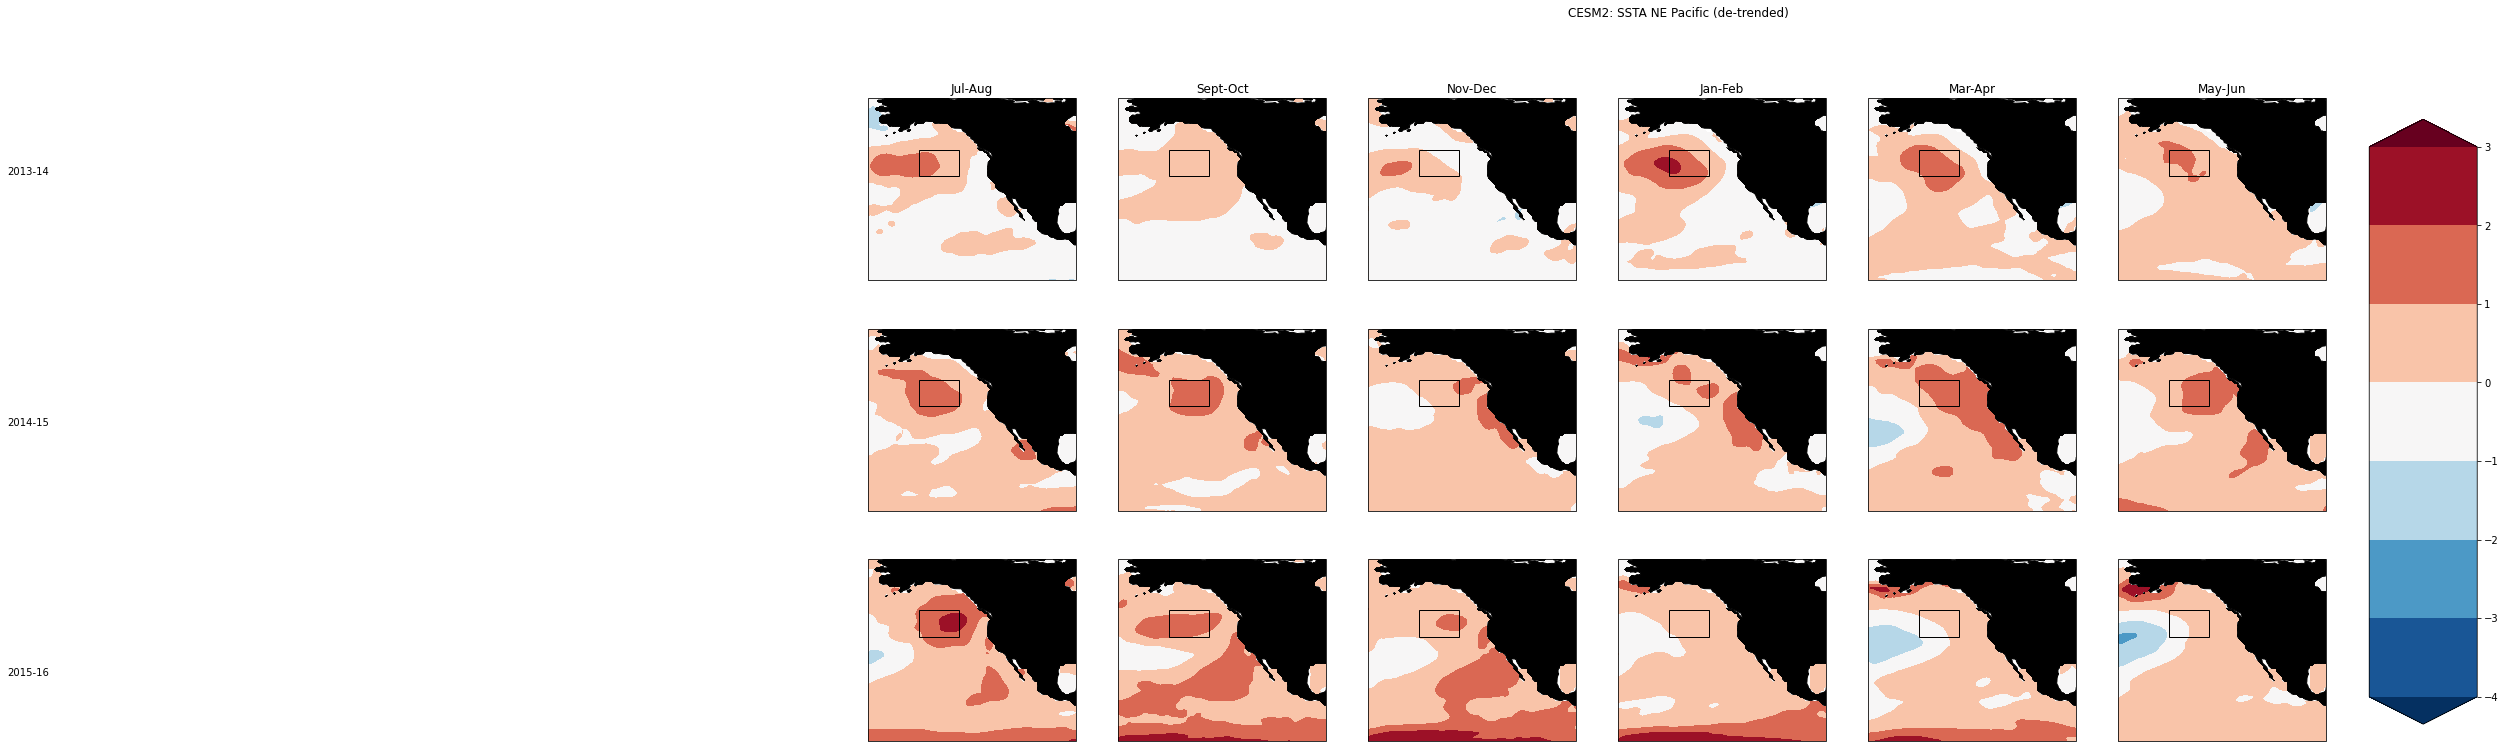

In [11]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step,cmap):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(30,12),
                          subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))) 
    axs = axs.flatten()
    for i in range(0,18):
        im = axs[i].contourf(cesm.lon, cesm.lat, cesm.isel(time=i),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap,
                         levels=np.arange(lower_bound, upper_bound, step),
                         extend='both')
        axs[i].add_feature(cfeature.LAND, color='k')
        axs[i].add_patch(mpatches.Rectangle(xy=[210, 40], width=15, height=10,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree())
                 )
    plt.suptitle("CESM2: " + description + " " + variable + " " + depth + " (de-trended)")
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-790,215,'2013-14')
    plt.text(-790,120,'2014-15')
    plt.text(-790,25,'2015-16')
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax,fraction=0.046,pad=0.04)
    
panels(tos,'SSTA','NE','Pacific',-4.0,4.0, 1.0,'RdBu_r')